## Anomaly detection with autoencoder
In this note, I review and demonstrate anomaly detection using autoencoder. For demonstration, I use Physics Exchange user dataset collected in my [other note](SQL_query.ipynb).

### Review: Autoencoder

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/37/Autoencoder_schema.png/659px-Autoencoder_schema.png" width="320px">
<div align=center> Autoencoder. Image from <a href=https://en.wikipedia.org/wiki/File:Autoencoder_schema.png>wikipedia</a> </div>


Autoencoder is a type of an artificial neural network whose input and output have the equal dimension. The first part of the network, encoder, encodes the input data $\mathbf{X}$ into the codes $\mathbf{h}$ which have smaller dimension than the input data. The second part of the network, decoder, has the symmetric structure with the encoder and it decodes the codes $\mathbf{h}$ to the output data $\mathbf{X'}$. The autoencoder does not produce any label output and therfore this is a model for unsupervised learning. It is trained with loss function that measures the difference between $\mathbf{X}$ and $\mathbf{X'}$, so the ideal autoencoder should produce an output looks very similar to the input data.

Due to the fact that autoencoder produces a likely, similar output data for a given input data, it can be used to image denoising or collaborative filtering for recommender systems. One might even use this to build generative models like Variational Autoencoder (VAE). As I would explain in the following paragraph, an autoencoder can be seen as a generalization of PCA. This allows one to use autoencoders for dimensionality reduction or anomaly detection.

### Autoencoder as  a generalization of PCA
As I explained in my [other note](anomaly_detection_PCA.ipynb), PCA can be used for anomaly detection by calculating Mahalanobis distance for each data. That is,
$$\begin{eqnarray}
& D(\mathbf{x}) = \sqrt{ \chi^T(\mathbf{x}) \chi(\mathbf{x}) },\quad
\chi(\mathbf{x})=V^{-1/2} M (\mathbf{x}-\mathbf{\mu}) \quad\text{where} \nonumber\\
& S = \text{E}\left[ \left(\mathbf{X}-\mathbf{\mu}\right) \otimes \left(\mathbf{X}-\mathbf{\mu}\right)^T \right]=M^{-1} V M, \quad V=\text{diag}(v_1,\cdots,v_p), \quad v_i\ge 0, \quad v_{i}\ge v_{i+1}.
\end{eqnarray}$$
In particular, PCA approximates this distance by truncating $\mathbf{V}$ as $\mathbf{V'}=\text{diag}(v_1,\cdots,v_n,0,\cdots,0)$. This truncation allows us to only first $n$ rows of $M$. With this, $\chi(\mathbf{x})$ is nothing but a linear model between the $p$-dimensional input data and the $n$-dimensional codes. Now by replacing all the activation functions with linear functions, the encoder part of the autoencoder becomes exactly the linear model with the same dimensionality. The same story can be repeated between $\chi(\mathbf{x})^T$ and the decoder part of the network, and the autoencoder is a generalization of PCA in this sense.

### Criterion for anomaly detection with autoencoder
In the anomaly detection using PCA, Mahalanobis distance is used for criterion to detect anomalies. From the discussion in the previous paragraph, this corresponds to the Euclidean distance in the space for codes $\mathbf{h}$. In case the symmetry between the encoder and the decoder is enforced, this can be indeed used for a criterion for anomaly detection. In case one relaxes the symmetry enforcement, however, the code in the middle of network is not a precise generalization of $\chi(\mathbf{x})$ in the previous paragraph and therefore cannot be used for the criterion. Instead, one can use some distance measure, such as MSE, between the input data $\mathbf{x}$ and the output data $\mathbf{x'}$. This is because the network is only trained with the data labeld as normal. So if one inputs an anomaly far away from the normal data, the autoencoder cannot produce an output similar enough to the original anomaly input. By setting some threshold for this distance measure, one can use autoencoders for anomaly detection.

### Demonstration with Physics Exchange user dataset
Now I demonstrate anomaly detection using autoencoder with Physics Exchange user dataset. The dataset is colleced through a SQL query on the Stack Exchange data extraction tool, Data Explorer. Used query is in my [other note](SQL_query.ipynb). The user data possibly can be used to measure user activity level are collected.

I first load relevant libraries. For neural network implementation, I use PyTorch.

In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt

Stack Exchange has the badge system to recognize the users with high activity level. Among the badges, gold badges are the rarest and I put the users with 5 gold badges or more as anomalies that have shown extraordinary activites in the website. Along this criteria, I divided the dataset into the normal dataset and the anomaly dataset. I also dropped badge columns and user IDs as well as min-max normalized the entired dataset. For exploration purpose, I presented a summary of normal dataset below.

In [2]:
df=pd.read_csv("PhysicsExchangeUsers.csv")
df=df.sample(frac=1,random_state=0)
df_anomaly=df[df["GoldBadges"]>5]
df_normal=df[df["GoldBadges"]<=5]

df_anomaly=(df_anomaly-df.min())/(df.max()-df.min())
df_normal=(df_normal-df.min())/(df.max()-df.min())

df_anomaly=df_anomaly.iloc[:,1:(-3)]
df_normal=df_normal.iloc[:,1:(-3)]

data_train=torch.tensor(df_normal.to_numpy()).float()
data_test=torch.tensor(df_anomaly.to_numpy()).float()
train_set=torch.utils.data.TensorDataset(data_train)
test_set=torch.utils.data.TensorDataset(data_test)

N_train, N_test = len(df_normal), len(df_anomaly)
print("Normal data:",len(df_normal))
print("Anomalies:",len(df_anomaly))
df_normal.describe()

Normal data: 49918
Anomalies: 82


,Reputation,DaysExisted,Views,UpVotes,DownVotes,QuestionViews,QuestionVotes,Questions,Answers,AcceptedAnswers
count,49918.000000,49918.000000,49918.000000,49918.000000,49918.000000,49918.000000,49918.000000,49918.000000,49918.000000,49918.000000
mean,0.000590,0.505954,0.000496,0.001403,0.000110,0.003753,0.016814,0.002976,0.000621,0.000390
std,0.003765,0.249512,0.003445,0.011092,0.001957,0.016394,0.011076,0.010405,0.005740,0.004013
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.317308,0.000000,0.000000,0.000000,0.000000,0.013955,0.000000,0.000000,0.000000
50%,0.000006,0.517094,0.000023,0.000067,0.000000,0.000000,0.013955,0.000000,0.000000,0.000000
75%,0.000175,0.685363,0.000181,0.000401,0.000000,0.001102,0.015152,0.002621,0.000000,0.000000
max,0.212665,1.000000,0.275312,1.000000,0.229824,0.943492,0.384370,0.507208,0.492530,0.343344


### Autoencoder structure
The current dataset has 10-dimensional data. I set my encoder and decoder to have two hidden layers with dimensions 64 and 24. By setting the code dimension to be 6, the entire network is composed of following layers:
1. Fully connected layer (10 units→64 units), followed by ReLU activation
2. Fully connected layer (64 units→24 units), followed by ReLU activation
3. Fully connected layer (24 units→6 units), followed by ReLU activation
4. Fully connected layer (6 units→24 units), followed by ReLU activation
5. Fully connected layer (24 units→64 units), followed by ReLU activation
6. Fully connected layer (64 units→10 units)
In this network, I do not enforce the symmetry between the encoder and the decoder. I use RMSprop for optmizer with mean squared error as the loss function. Here I also set the learning rate and initialization of the network.

In [3]:
hdim1, hdim2, code_dim = 64, 24, 6

class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq=nn.Sequential(
            nn.Linear(10,hdim1),nn.ReLU(),
            nn.Linear(hdim1,hdim2),nn.ReLU(),
            nn.Linear(hdim2,code_dim),nn.ReLU(),
            nn.Linear(code_dim,hdim2),nn.ReLU(),
            nn.Linear(hdim2,hdim1),nn.ReLU(),
            nn.Linear(hdim1,10)
        )
    def forward(self,data):
        return self.seq(data)

learn_rate=0.0001
auto_enc=AutoEncoder()
auto_enc_optimizer=torch.optim.RMSprop(
    auto_enc.parameters(), lr=learn_rate
)
loss_fn=nn.MSELoss()

def initialization(layer):
    if type(layer)==nn.Linear:
        nn.init.normal_(layer.weight, 0, 0.02)
        nn.init.constant_(layer.bias, 0)
auto_enc=auto_enc.apply(initialization)

### Training the model

I train the model for 12 epochs with batch size 128. To check the progress, I present the loss history after each epoch.

100%|██████████| 390/390 [00:00<00:00, 428.27it/s]


epoch  1 : loss= 0.011864844175477424


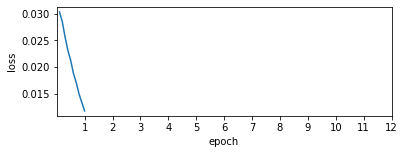

100%|██████████| 390/390 [00:00<00:00, 410.51it/s]


epoch  2 : loss= 0.008313907021078055


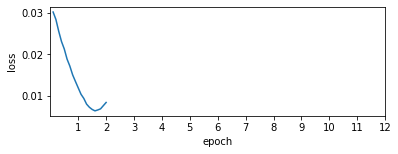

100%|██████████| 390/390 [00:00<00:00, 407.74it/s]


epoch  3 : loss= 0.007573337975949168


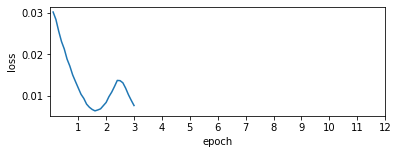

100%|██████████| 390/390 [00:00<00:00, 413.70it/s]


epoch  4 : loss= 0.007754601579241619


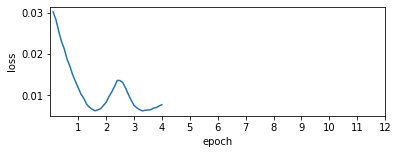

100%|██████████| 390/390 [00:01<00:00, 357.77it/s]


epoch  5 : loss= 0.008414886293854408


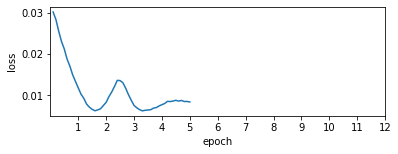

100%|██████████| 390/390 [00:01<00:00, 291.63it/s]


epoch  6 : loss= 0.0062233182110773295


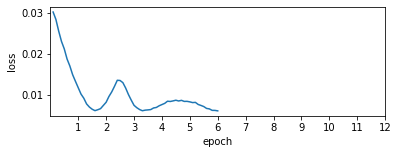

100%|██████████| 390/390 [00:01<00:00, 283.98it/s]


epoch  7 : loss= 0.0068597174772175255


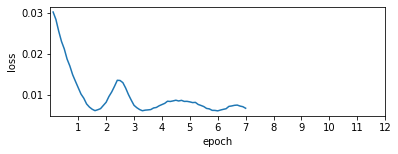

100%|██████████| 390/390 [00:01<00:00, 374.56it/s]


epoch  8 : loss= 0.006300212090316122


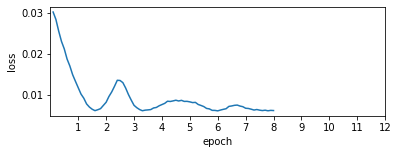

100%|██████████| 390/390 [00:01<00:00, 310.27it/s]


epoch  9 : loss= 0.006653704379455659


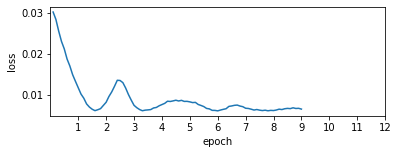

100%|██████████| 390/390 [00:01<00:00, 363.59it/s]


epoch  10 : loss= 0.006293209127984747


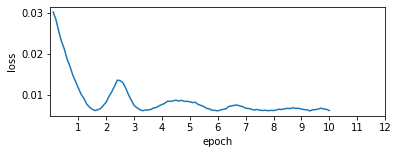

100%|██████████| 390/390 [00:01<00:00, 363.67it/s]


epoch  11 : loss= 0.006222523870189228


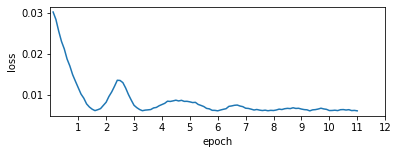

100%|██████████| 390/390 [00:01<00:00, 383.01it/s]


epoch  12 : loss= 0.006215873712446085


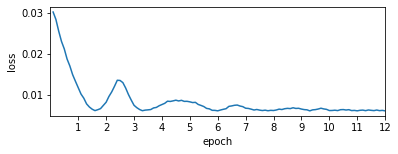

In [4]:
n_epoch=12
batch_size=128
steps_per_epoch=10

train_dataloader=torch.utils.data.DataLoader(train_set,batch_size=batch_size)

loss_history=[]
for epoch in range(n_epoch):
    sample_cnt=0
    sample_cnt_epoch=0
    loss_sum=0
    for data in tqdm(train_dataloader):
        data=data[0]
        len_batch=len(data)
        pred=auto_enc(data)
        loss=loss_fn(pred,data)
        loss_sum+=loss.item()*len_batch
        loss.backward()
        auto_enc_optimizer.step()
        
        sample_cnt+=len_batch
        sample_cnt_epoch+=len_batch
        
        if (sample_cnt*steps_per_epoch>=N_train) or (sample_cnt_epoch==N_train):
            loss_avg=loss_sum/sample_cnt
            loss_history.append(loss_avg)
            loss_sum=0
            sample_cnt=0
    print("epoch ",epoch+1,": loss=",loss_avg)
    plt.figure(figsize=(6,2))
    plt.plot(range(1,len(loss_history)+1),loss_history)
    plt.xlim(0,n_epoch*steps_per_epoch)
    plt.xticks(list(range(steps_per_epoch,steps_per_epoch*n_epoch+1,steps_per_epoch))
                ,list(range(1,n_epoch+1)))
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

### Anomaly detection
After training the autoencoder, I calculate the mean squared error between the input and the output, for both of the normal dataset and the anomaly dataset. Log-histogram is presented to visually see how these two datasets are different.

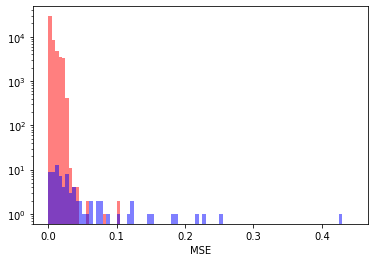

In [5]:
auto_enc.eval()
pred_train=auto_enc(data_train).detach().numpy()
pred_test=auto_enc(data_test).detach().numpy()
err_normal=pred_train-df_normal.to_numpy()
err_anomaly=pred_test-df_anomaly.to_numpy()

MSE_normal=np.sum(err_normal**2,axis=1)/pred_train.shape[1]
MSE_anomaly=np.sum(err_anomaly**2,axis=1)/pred_test.shape[1]

plt.figure()
plt.hist(MSE_normal,log=True,bins=np.arange(0,0.45,0.005),
         color="r",alpha=0.5)
plt.hist(MSE_anomaly,log=True,bins=np.arange(0,0.45,0.005),
         color="b",alpha=0.5)
plt.xlabel("MSE");

To assess the performance as anomaly detecter, I calculate the precision, recall, and F1 score for different thresholds for the mean squared error. It seems F1 score is optimized around the threshold of 0.03, while the precision is saturated around the threshold of 0.1.

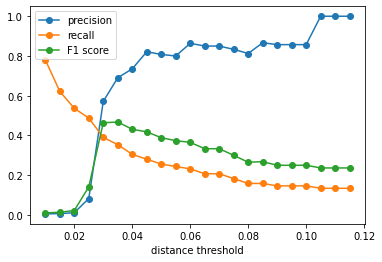

Max F1 score: 0.46774193548387094


In [6]:
mses=np.arange(0.01,0.12,0.005)
precisions=[]
recalls=[]
F1s=[]
for mse_thre in mses:
    TN=sum((MSE_normal<mse_thre)*1)
    FN=sum((MSE_anomaly<mse_thre)*1)
    FP=sum((MSE_normal>=mse_thre)*1)
    TP=sum((MSE_anomaly>=mse_thre)*1)

    precision=TP/(TP+FP)
    recall=TP/(TP+FN)
    F1=2*(precision*recall)/(precision+recall)
    precisions.append(precision)
    recalls.append(recall)
    F1s.append(F1)
plt.figure()
plt.plot(mses,precisions,"-o")
plt.plot(mses,recalls,"-o")
plt.plot(mses,F1s,"-o")
plt.xlabel("distance threshold")
plt.legend(["precision","recall","F1 score"])
plt.show()
print("Max F1 score:",max(F1s))

Another way to quantiy the performance of an anomaly detector is plotting the ROC curve. ROC curve is the plot of the true positive rate (TPR, or recall) versus the false postive rate (FPR, or fall-out). If the threshold is set to the infinty, no data is classified as anomaly and both TPR and FPR are 0. On the other hand, if the threshold is set to 0, every data is classfied as anomaly and both TPR and FPR are 1. A straight line between those two extremes are the performance of random detector. The area under the curve, AUC, of the ROC curve can be used to quantiy the overall performance of the detector. Random detector has AUC of 0.5, and a perfect detector has AUC of 1.

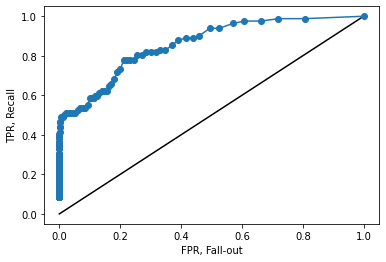

Estimated AUC = 0.8598685991367306


In [7]:
mses=np.arange(0,0.15,0.0005)
TPRs=[]
FPRs=[]
for mse_thre in mses:
    TN=sum((MSE_normal<mse_thre)*1)
    FN=sum((MSE_anomaly<mse_thre)*1)
    FP=sum((MSE_normal>=mse_thre)*1)
    TP=sum((MSE_anomaly>=mse_thre)*1)
    TPRs.append(TP/(TP+FN))
    FPRs.append(FP/(FP+TN))

sortedROC = sorted(zip(FPRs,TPRs))
FPRs=[x for x,_ in sortedROC]
TPRs=[y for _,y in sortedROC]
    
AUC=0
for i in range(len(mses)-1):
    AUC += (TPRs[i]+TPRs[i+1])*(FPRs[i+1]-FPRs[i])/2

plt.figure()
plt.plot([0,1],[0,1],color="k")
plt.plot(FPRs,TPRs,"-o")
plt.xlabel("FPR, Fall-out")
plt.ylabel("TPR, Recall")
plt.show()

print("Estimated AUC =",AUC)